# k1lib.schedule module

This essentially allows you to construct schedules intuitive and fast. Let's get into it:

In [1]:
from k1lib.imports import *
from k1lib.bioinfo.cli import *

A schedule is just a function with domain `[0, 1]` (input range of values). You can create anything you want like this:

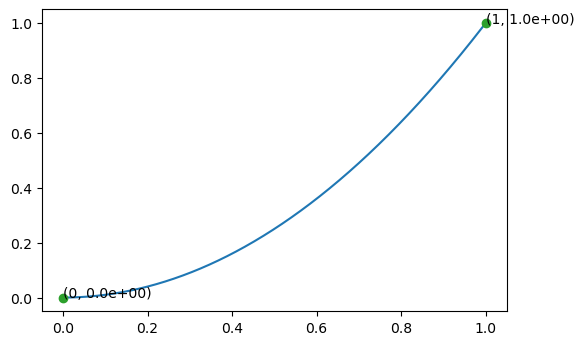

'None' schedule. Can...
- s.progress: to get last recorded progress
- s.value: to get last recorded hyper parameter's value
- s(0.3): to get value of schedule at 30% progress

In [2]:
s = schedule.Fn(lambda x: x**2); s

You can still call the function like before:

In [3]:
s(0.5)

0.25

There are several built-in schedules to help you out:

In [4]:
dir(schedule)[2:]

['exp', 'hump', 'linear', 'smooth']

You can also combine them together, like this:

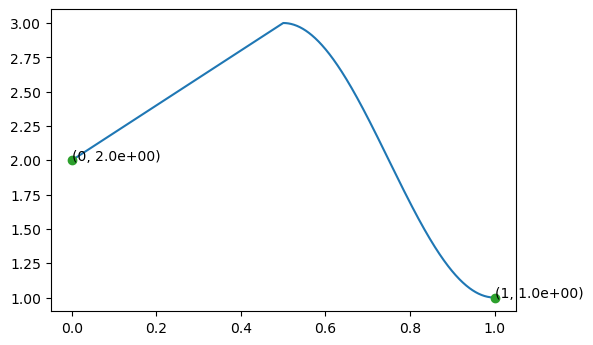

'None' schedule. Can...
- s.progress: to get last recorded progress
- s.value: to get last recorded hyper parameter's value
- s(0.3): to get value of schedule at 30% progress

In [5]:
schedule.linear(2, 3) + schedule.smooth(3, 1)

You can also combine them asymmetrically, like this:

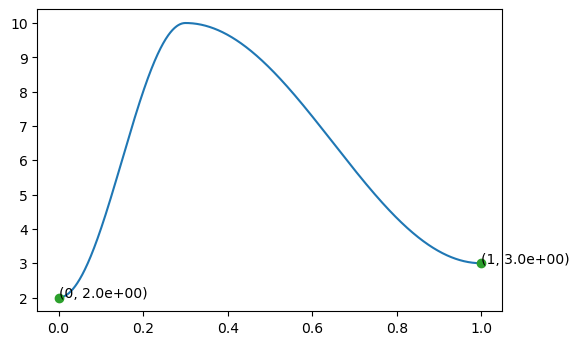

'None' schedule. Can...
- s.progress: to get last recorded progress
- s.value: to get last recorded hyper parameter's value
- s(0.3): to get value of schedule at 30% progress

In [6]:
.3 * schedule.smooth(2, 10) + .7 * schedule.smooth(10, 3)

Crazy ones like this works too!

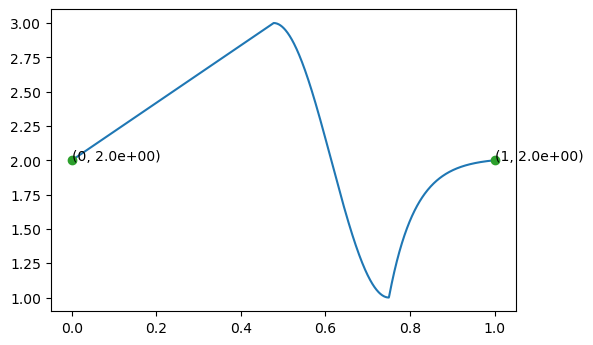

'None' schedule. Can...
- s.progress: to get last recorded progress
- s.value: to get last recorded hyper parameter's value
- s(0.3): to get value of schedule at 30% progress

In [7]:
(0.7 * schedule.linear(2, 3) + 0.4 * schedule.smooth(3, 1)) * 3 + schedule.exp(1, 2)

### ParamScheduler

You can also change a parameter inside a network while it's training according to a schedule. Here, the network is just trying to fit data for the function $x^2$:

In [8]:
x = torch.linspace(-2, 2, 300); y = x**2
t = [x, y] | transpose() | batched(32) | (transpose() | toTensor()).all() | deref()
def test(): plt.plot(x, l(x[:, None]) | toTensor());

In [9]:
def newL():
    l = k1lib.Learner()
    l.data = [t, []]
    l.model = nn.Sequential(nn.Linear(1, 10), nn.ReLU(), nn.Linear(10, 10), nn.ReLU(), nn.Linear(10, 1))
    l.lossF = lambda y, yB: ((y - yB)**2).sum()
    l.opt = optim.Adam(l.model.parameters(), 1e-3)
    l.cbs.withModifyBatch(lambda xb, yb: (xb[:,None], yb))
    return l

Here is vanilla version, without changing optimizer's learning rate:

Progress: 100%, epoch:  99/100, batch: 8/9, elapsed:   1.94s, loss: 152.44943237304688             

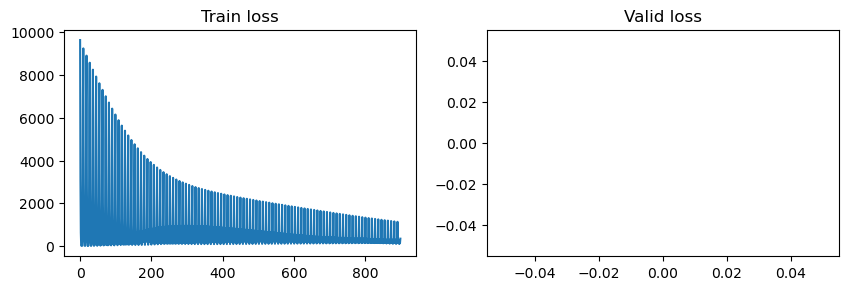

Sliceable plot. Can...
- p[a:b]: to focus on a specific range of the plot
- p.yscale("log"): to perform operation as if you're using plt

Reminder: the actual slice you put in is for the training plot. The valid loss's plot will update automatically to be in the same time frame

In [10]:
l = newL(); l.run(100); l.Loss.plot()

Batch cancelled: .


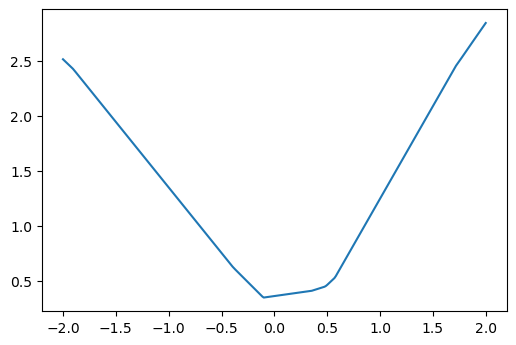

In [11]:
test()

Let's define our lr schedule:

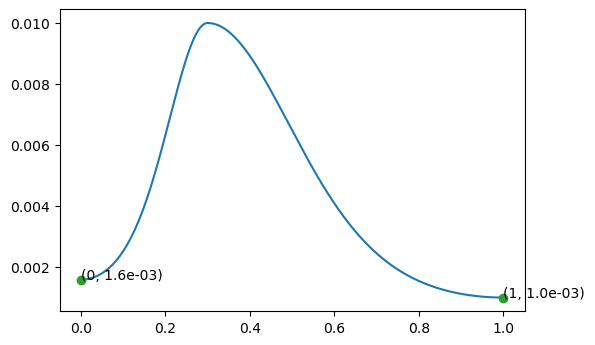

'lr' schedule. Can...
- s.progress: to get last recorded progress
- s.value: to get last recorded hyper parameter's value
- s(0.3): to get value of schedule at 30% progress

In [12]:
s = schedule.hump(-3, -2, "lr").modifyOutput(lambda x: 10**x); s

Note how here, we've added the term "lr" at the end of `schedule.hump`, to signify that this is a schedule for the "lr" hyperparameter. Let's train it:

Progress: 100%, epoch:  99/100, batch: 8/9, elapsed:   2.01s, loss: 187.8585205078125              

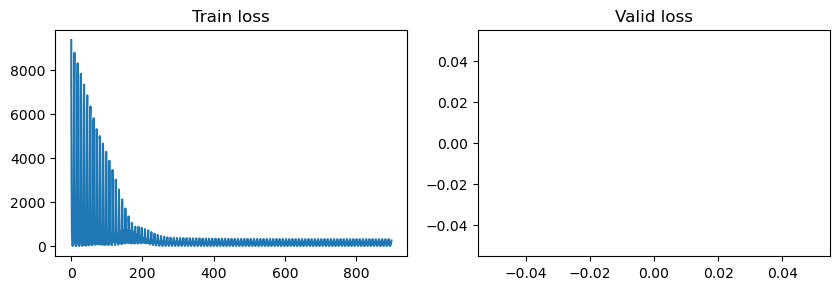

Sliceable plot. Can...
- p[a:b]: to focus on a specific range of the plot
- p.yscale("log"): to perform operation as if you're using plt

Reminder: the actual slice you put in is for the training plot. The valid loss's plot will update automatically to be in the same time frame

In [13]:
l = newL(); l.cbs.withParamScheduler("*", s)
l.run(100); l.Loss.plot()

Here, notice how we pass `*` to `withParamScheduler()`. This tells us that we want to apply the scheduling on the entire network.

Batch cancelled: .


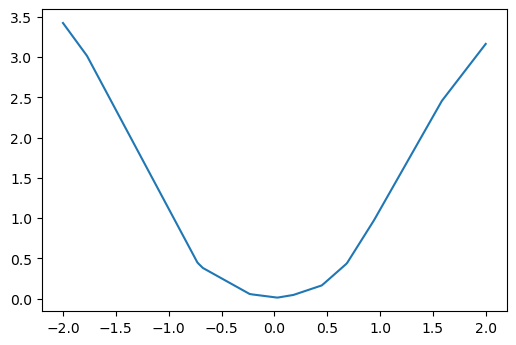

In [14]:
test()

And as you can see, it trains much quicker, and the resulting graph looks smoother than before! Let's try apply the schedule to the first layer only:

Progress: 100%, epoch:  99/100, batch: 8/9, elapsed:    2.0s, loss: 149.3910675048828              

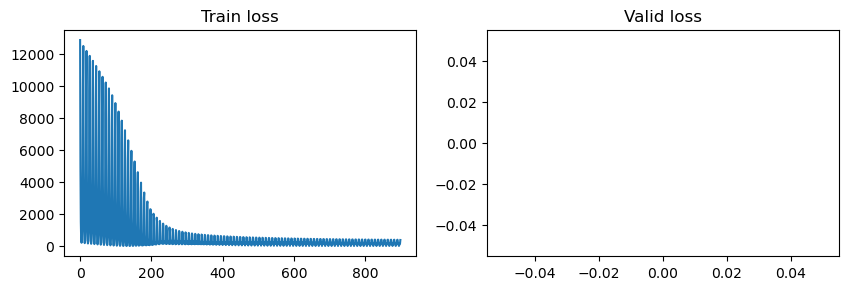

Sliceable plot. Can...
- p[a:b]: to focus on a specific range of the plot
- p.yscale("log"): to perform operation as if you're using plt

Reminder: the actual slice you put in is for the training plot. The valid loss's plot will update automatically to be in the same time frame

In [15]:
l = newL(); l.cbs.withParamScheduler("#root > #0", s)
l.run(100); l.Loss.plot()

Loss seems to go down not as fast as the 2nd network. Nevertheless, this demonstrates how we can schedule parts of the network only.